In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from estimate import *
import seaborn as sns
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 15})

# Training and test data

In [2]:
df = pd.read_csv("data/dataset_rpe1.csv")
interv_label = df['interventions']
groups = df.groupby(['interventions'])
## centralize data
df.iloc[:,:-1] = df.iloc[:,:-1] - groups.get_group('non-targeting').iloc[:,:-1].mean()
## observational data
data_obs = groups.get_group('non-targeting').iloc[:,:-1].to_numpy()
## interventional data
interv_obs = df.columns[:-1].to_numpy()
interv_hidden = set(interv_label) - set(interv_obs) - set(['non-targeting'])
data_interv_obs = []
data_interv_hidden = []
for interv_i in interv_obs:
    data_interv_obs.append(groups.get_group(interv_i).iloc[:,:-1].to_numpy())
for interv_i in interv_hidden:
    data_interv_hidden.append(groups.get_group(interv_i).iloc[:,:-1].to_numpy())
data_interv_obs = dict(zip(interv_obs, data_interv_obs))
data_interv_hidden = dict(zip(interv_hidden, data_interv_hidden))
train_data = [data_obs] + list(data_interv_obs.values())

In [3]:
## test environments where observational OLS performs the worst
test_mse_ols_obs = np.array(test_mse_list(list(data_interv_hidden.values()), est(train_data, method='ols_obs')))
env_idx = test_mse_ols_obs.argsort()[::-1][:50]
data_test_large_shift = [list(data_interv_hidden.values())[i] for i in env_idx]
data_test_large_shift_gene = [list(data_interv_hidden.keys())[i] for i in env_idx]

# DRIG and anchor regression

In [4]:
gammas = np.linspace(0, 20, 100)
num_gammas = len(gammas)
num_envs = len(data_test_large_shift)
results = None
mses_drig = []
mses_anc = []
for i in range(num_gammas):
    mses_drig = test_mse_list(data_test_large_shift, est(train_data, method='drig', gamma=gammas[i]))
    mses_anc = test_mse_list(data_test_large_shift, est(train_data, method='anchor', gamma=gammas[i]))
    result = pd.DataFrame({
        'method': np.concatenate([np.repeat('DRIG', num_envs), np.repeat('anchor regression', num_envs)], axis=0),
        'gamma': np.repeat(gammas[i], num_envs*2),
        'interv_gene': data_test_large_shift_gene*2,
        'test_mse': np.concatenate([mses_drig, mses_anc], axis=0)
    })
    results = result if results is None else pd.concat([results, result], ignore_index=True)

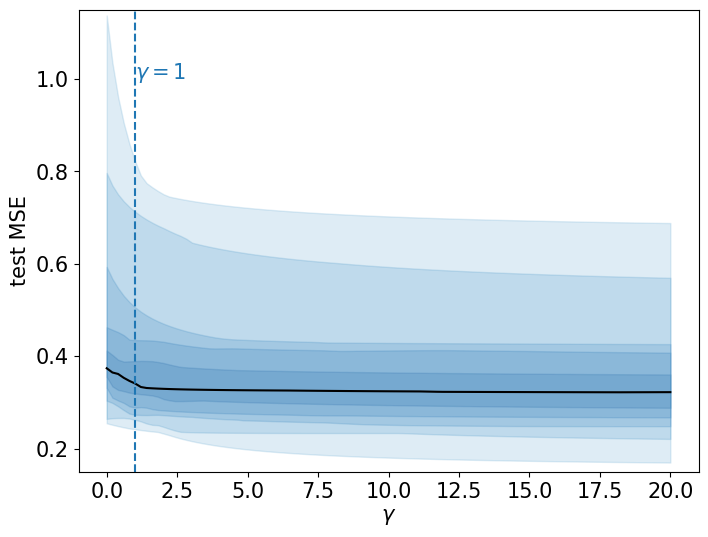

In [5]:
results_drig = results.loc[results['method']=='DRIG']
fig,ax = plt.subplots(1,1)
sns.lineplot(data=results_drig, x='gamma', y='test_mse', estimator='median', errorbar=None, ax=ax, color='black')
pi_range = np.arange(20, 101, 20)
cm = sns.color_palette("Blues", len(pi_range) + 5)
for ix,pi in enumerate(pi_range):
    sns.lineplot(data=results_drig, x="gamma", y="test_mse",
                 errorbar=('pi', pi),
                 ax=ax, linestyle='',
                 hue = pi, palette={pi:cm[len(pi_range)-1-ix + 5]}, legend=False)
plt.axvline(x=1, linestyle='dashed'); plt.text(x=1, y=1, s=r'$\gamma=1$', c='C0')
plt.ylabel('test MSE'); plt.xlabel(r'$\gamma$'); plt.ylim(0.15,1.15)
# plt.savefig('drig_test_gammas_worst50.pdf', bbox_inches='tight'); 
plt.show()

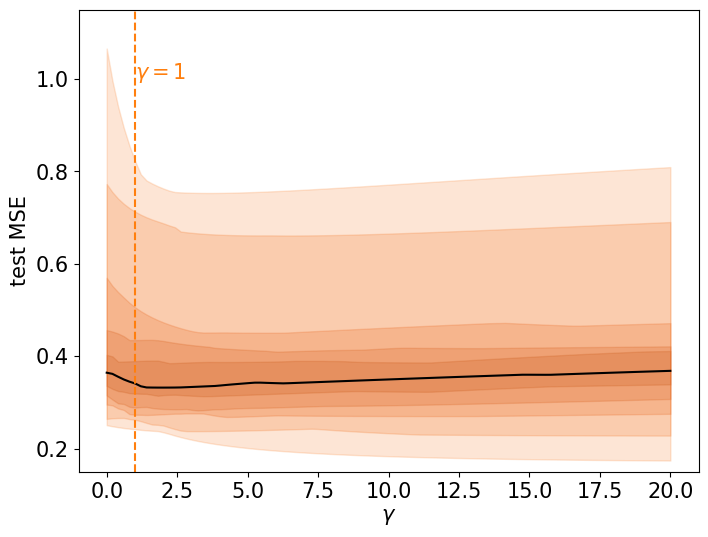

In [6]:
results_anc = results.loc[results['method']=='anchor regression']
fig,ax = plt.subplots(1,1)
sns.lineplot(data=results_anc, x='gamma', y='test_mse', estimator='median', errorbar=None, ax=ax, color='black')
pi_range = np.arange(20, 101, 20)
cm = sns.color_palette("Oranges", len(pi_range) + 5)
for ix,pi in enumerate(pi_range):
    sns.lineplot(data=results_anc, x="gamma", y="test_mse",
                 errorbar=('pi', pi),
                 ax=ax, linestyle='',
                 hue = pi, palette={pi:cm[len(pi_range)-1-ix + 5]}, legend=False)
plt.axvline(x=1, linestyle='dashed', c='C1'); plt.text(x=1, y=1, s=r'$\gamma=1$', c='C1')
plt.ylabel('test MSE'); plt.xlabel(r'$\gamma$'); plt.ylim(0.15,1.15)
# plt.savefig('anchor_test_gammas_worst50.pdf', bbox_inches='tight'); 
plt.show()

# DRIG-A

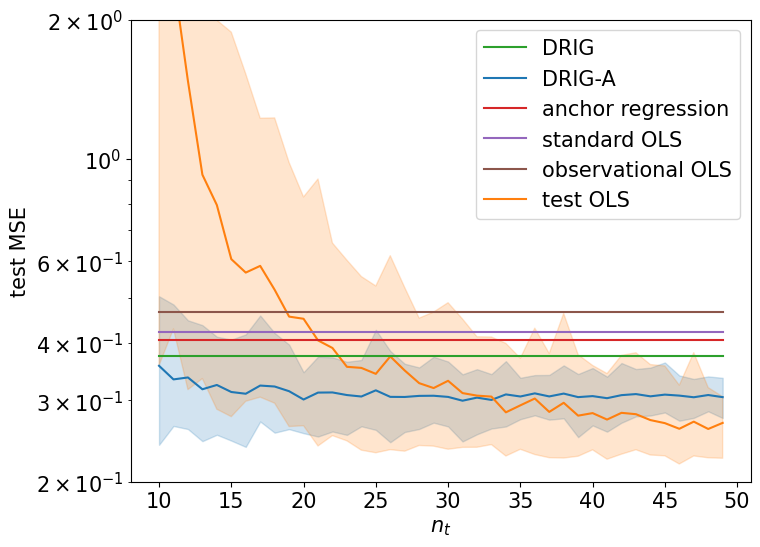

In [7]:
env_idx = test_mse_ols_obs.argsort()[::-1][:50]
data_test_large_shift = [list(data_interv_hidden.values())[i] for i in env_idx]
data_test_large_shift = np.concatenate(data_test_large_shift, axis=0)
data_test_full = data_test_large_shift
results = pd.DataFrame(columns=['method', 'n_te', 'id', 'test_mse'])
n_te_all = np.arange(10, 50, 1)
for n_te in n_te_all:
    for i in range(50):
        subsample_idx = np.random.choice(len(data_test_full), n_te, replace=False)
        data_test_tr = data_test_full[subsample_idx]
        data_test_eval = np.delete(data_test_full, subsample_idx, 0)
        mse_driga = test_mse(data_test_eval, est_drig_adap(train_data, data_test_tr, unif_weight=False))
        results = results.append({'method': 'DRIG-A', 'n_te': n_te, 'id': i, 'test_mse': mse_driga}, ignore_index=True)
        mse_tols = test_mse(data_test_eval, est([data_test_tr], method='ols_obs'))
        results = results.append({'method': 'test OLS', 'n_te': n_te, 'id': i, 'test_mse': mse_tols}, ignore_index=True)
mse_ols_pool = test_mse(data_test_eval, est(train_data, method='ols_pool', unif_weight=False))
mse_ols_obs = test_mse(data_test_eval, est(train_data, method='ols_obs', unif_weight=False))
sns.lineplot(data=results, x='n_te', y='test_mse', hue='method', errorbar='pi')
plt.plot(n_te_all, np.repeat(test_mse(data_test_eval, est(train_data, method='drig', gamma=10, unif_weight=False)), len(n_te_all)), label='DRIG')
plt.plot(n_te_all, np.repeat(test_mse(data_test_eval, est(train_data, method='anchor', gamma=10, unif_weight=False)), len(n_te_all)), label='anchor regression')
plt.plot(n_te_all, np.repeat(mse_ols_pool, len(n_te_all)), label='standard OLS')
plt.plot(n_te_all, np.repeat(mse_ols_obs, len(n_te_all)), label='observational OLS')
plt.yscale('log')
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,3,4,5,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.ylim(0.2, 2); plt.ylabel('test MSE'); plt.xlabel(r'$n_t$')
# plt.savefig('results_adap_worst50.pdf')
plt.show()